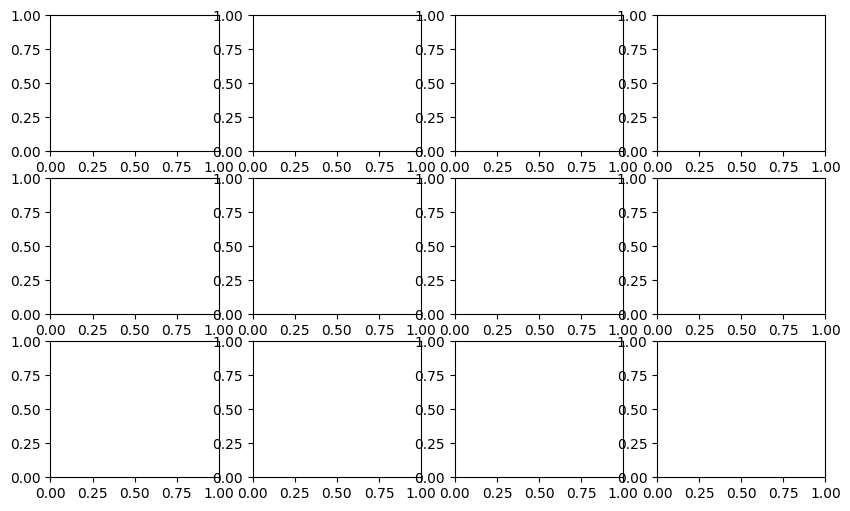

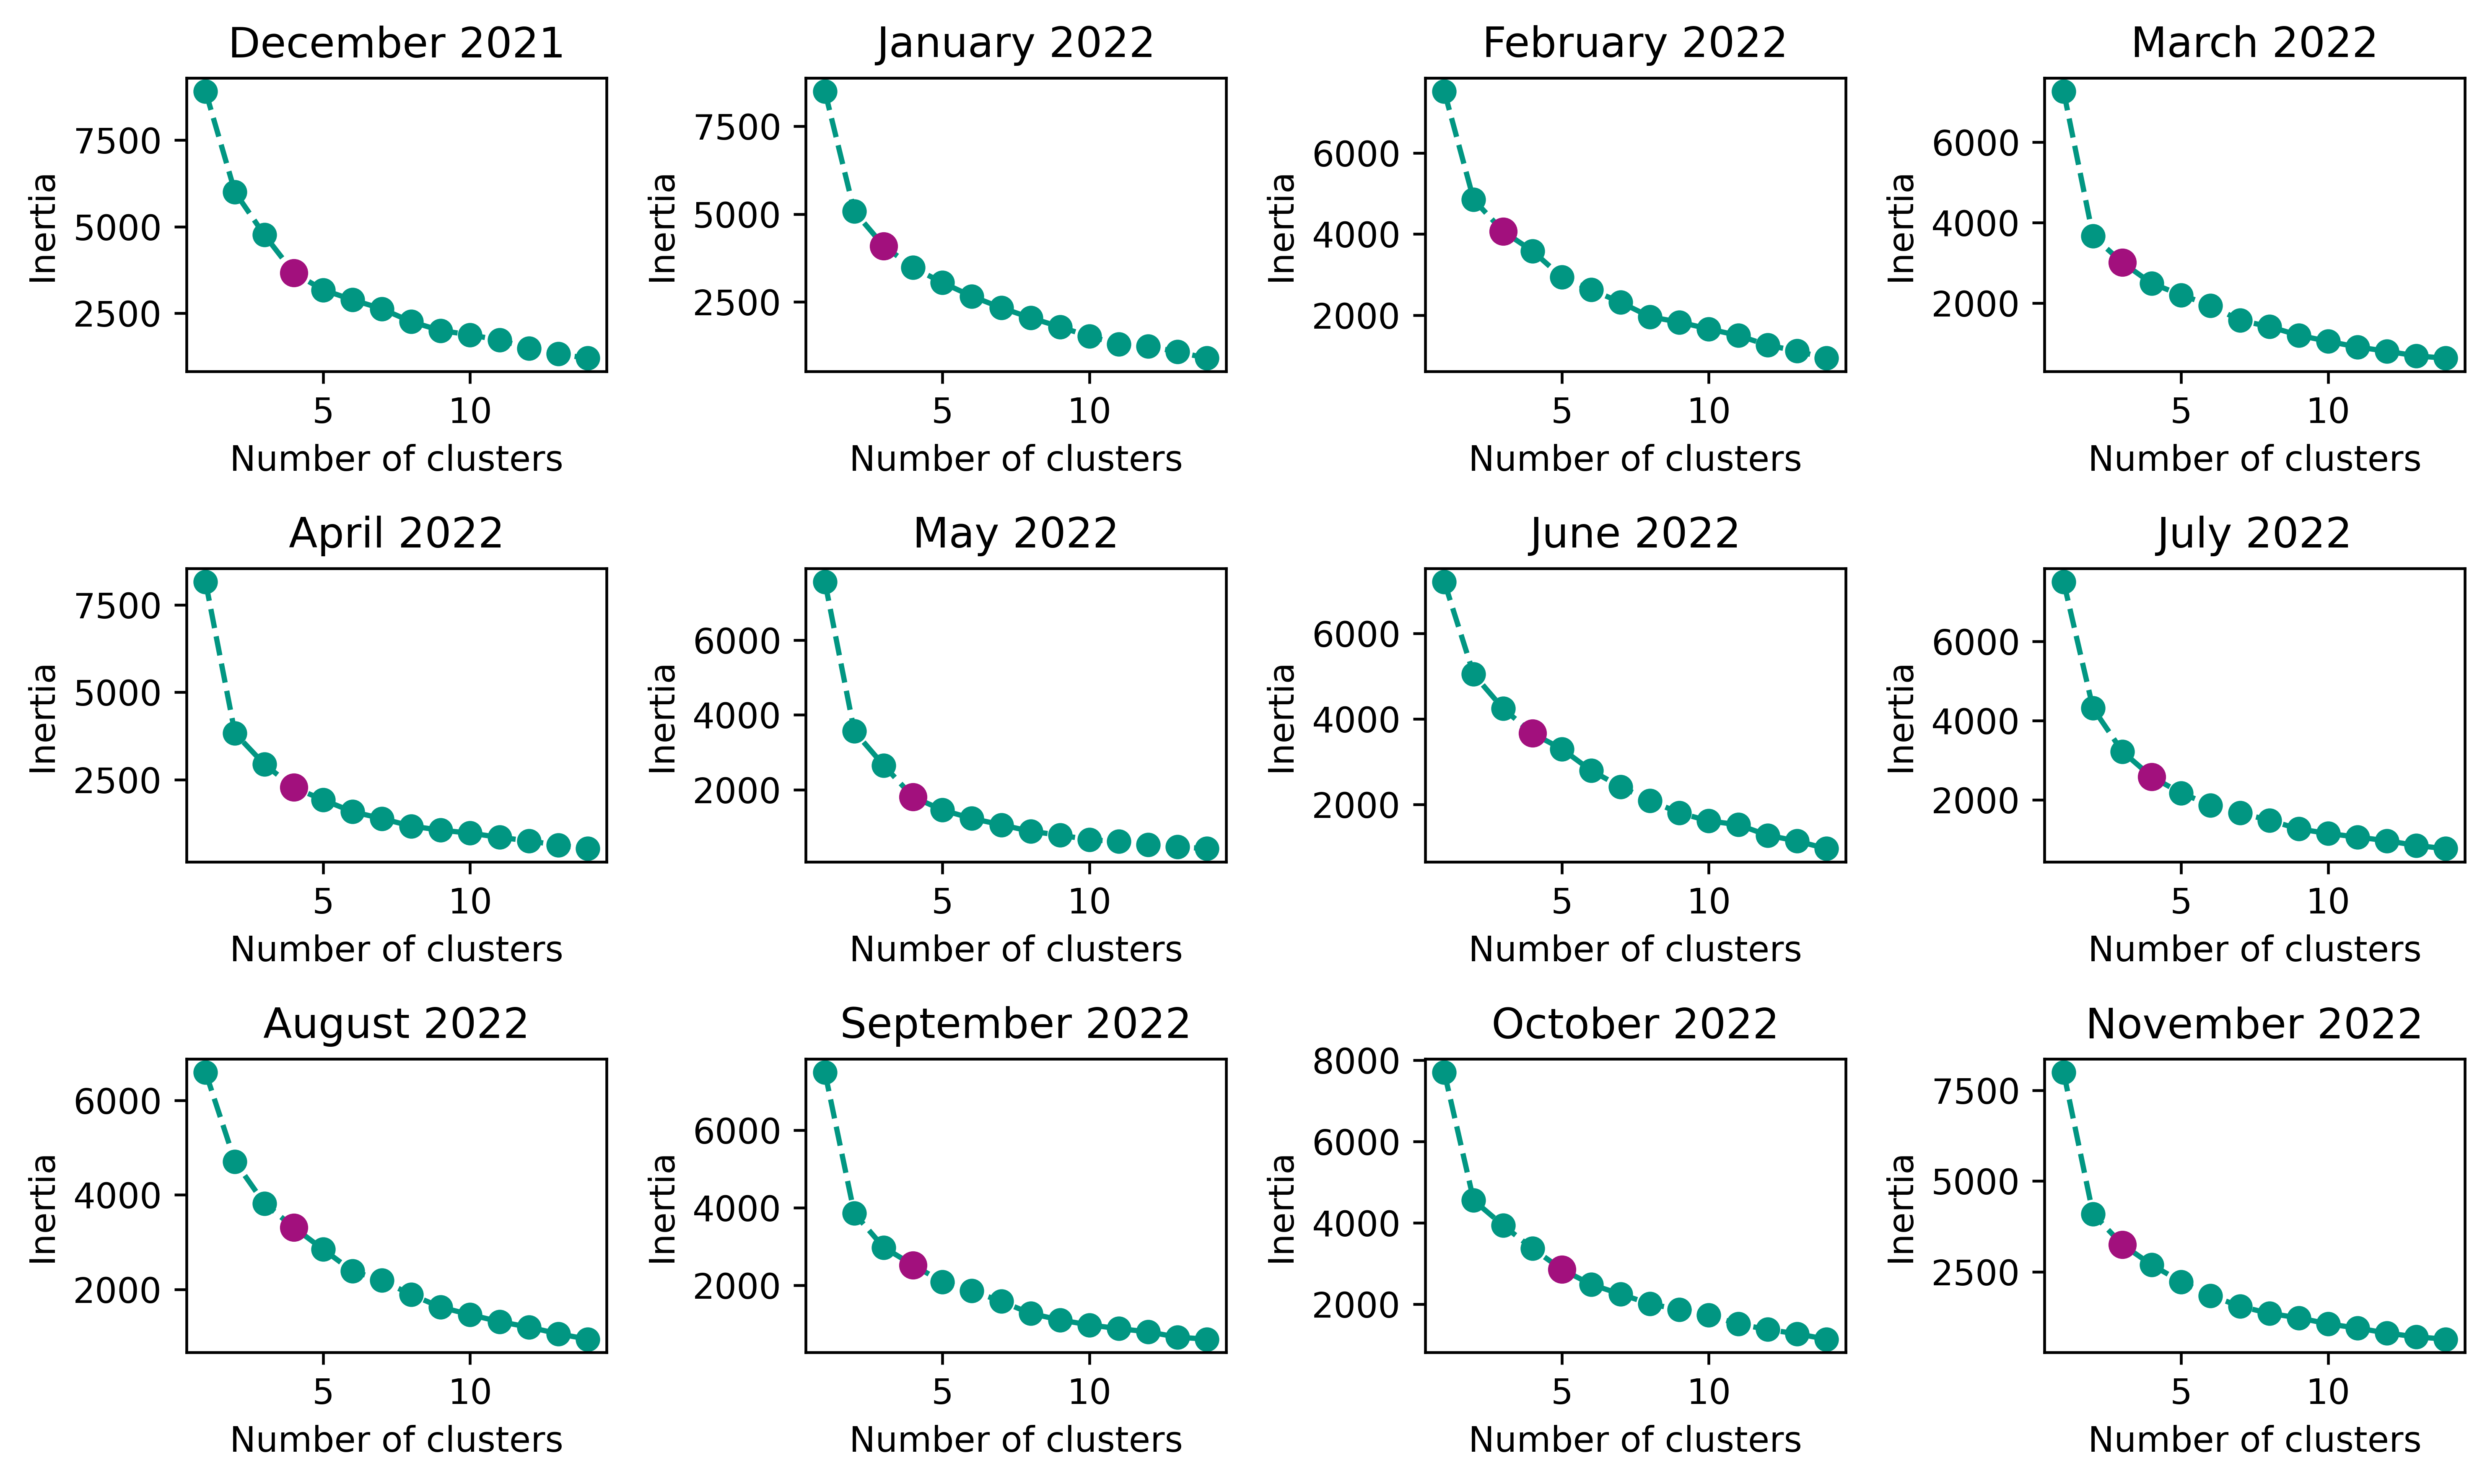

Total Profit for 2022: 85596.74


<Figure size 640x480 with 0 Axes>

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from entsoe import EntsoePandasClient
import psycopg2

ENTSOE_API_KEY = ""
client = EntsoePandasClient(api_key=ENTSOE_API_KEY)


CONNECTION = ""
conn = psycopg2.connect(CONNECTION)

def get_max_profit_params(cluster_days, conn):
    """
    For given cluster days, get the parameter combination that maximizes the profit.
    """
    query = f"""
    SELECT threshold, threshold_abs, discount_rate, SUM(profit) as total_profit
    FROM revenues_1_cycle_max_h
    WHERE day IN ({', '.join(["'" + str(day) + "'" for day in cluster_days])})
    GROUP BY threshold, threshold_abs, discount_rate
    ORDER BY total_profit DESC
    LIMIT 1;
    """
    
    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchone()
    cursor.close()
    
    return {
        "threshold": result[0],
        "threshold_abs": result[1],
        "discount_rate": result[2],
        "total_profit_2021": result[3]
    }

def get_profit_for_params_2022(cluster_days, params, conn):
    """
    Given the ideal parameters, compute the profit for 2022 data for given cluster days.
    """
    query = f"""
    SELECT SUM(profit) as total_profit
    FROM revenues_1_cycle_max_h
    WHERE day IN ({', '.join(["'" + str(day) + "'" for day in cluster_days])})
    AND threshold = '{params['threshold']}'
    AND threshold_abs = '{params['threshold_abs']}'
    AND discount_rate = '{params['discount_rate']}';
    """
    
    cursor = conn.cursor()
    cursor.execute(query)
    profit = cursor.fetchone()[0]
    cursor.close()
    
    return profit


# Setting up the grid of plots
fig, axes = plt.subplots(3, 4, figsize=(10 , 6))
months = [
    'December 2021', 'January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
    'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022'
]

months_years = [
    (2021, 12), (2022, 1), (2022, 2), (2022, 3), (2022, 4), (2022, 5),
    (2022, 6), (2022, 7), (2022, 8), (2022, 9), (2022, 10), (2022, 11)
]

highlighted_points = [4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 3]

def get_month_data(year, month):
    """
    Returns the data for given year and month.
    """
    start = pd.Timestamp(f'{year}-{month}-01', tz='Europe/Berlin')
    end = start + relativedelta(months=1)
    
    load = client.query_load_forecast("DE_LU", start=start, end=end)
    wind_solar_forecast = client.query_wind_and_solar_forecast("DE_LU", start=start,end=end, psr_type=None)
    df_merged = pd.merge(load, wind_solar_forecast, left_index=True, right_index=True)
    
    day_ahead_prices = client.query_day_ahead_prices("DE_LU", start=start,end=end)
    day_ahead_prices.name = "Day Ahead Prices"
    df_merged = pd.merge(df_merged, day_ahead_prices, how='left', left_index=True, right_index=True)
    df_merged = df_merged.fillna(0)
    
    return df_merged

def analyze_yearly_profits(conn):
    """
    Analyzes the profit over the year based on clustering each month and using the 
    parameters to predict the next month's clusters.
    """
    previous_cluster_centers = None
    previous_max_profit_params = None
    total_profit_2022 = 0
    
    fig, axes = plt.subplots(3, 4, figsize=(10, 6), dpi = 600)

    for i in range(3):
        for j in range(4):
            month_idx = i * 4 + j
            year, month = months_years[month_idx]
            df = get_month_data(year, month)
            
            # Data Preprocessing
            scaler = StandardScaler()
            df_scaled = df.copy()
            df_scaled[df.columns] = scaler.fit_transform(df)

            # Extracting Day-wise Features
            days = np.unique(df_scaled.index.date)
            n_intervals = 96  # 24 hours * 4 (15-minute intervals)
            data_dict = {}
            for day in days:
                daily_data = df_scaled[df_scaled.index.date == day]
                if daily_data.shape[0] == n_intervals:
                    flattened_data = daily_data.values.flatten()
                    data_dict[day] = flattened_data

            df_days = pd.DataFrame.from_dict(data_dict, orient='index')
            
            kmeans_current = KMeans(n_clusters=highlighted_points[month_idx], random_state=0).fit(df_days)
            cluster_centers_current = kmeans_current.cluster_centers_
            cluster_labels_current = kmeans_current.labels_

            if previous_cluster_centers is not None:
                kmeans_predict = KMeans(n_clusters=len(previous_cluster_centers), init=previous_cluster_centers, n_init=1, max_iter=1).fit_predict(df_days)
                for cluster in range(len(previous_cluster_centers)):
                    cluster_days = df_days.index[kmeans_predict == cluster]
                    profit = get_profit_for_params_2022(cluster_days, previous_max_profit_params, conn)
                    total_profit_2022 += profit

            for cluster in range(highlighted_points[month_idx]):
                cluster_days = df_days.index[cluster_labels_current == cluster]
                previous_max_profit_params = get_max_profit_params(cluster_days, conn)
            
            previous_cluster_centers = cluster_centers_current
            
            # K-Means with Elbow Method
            inertia = []
            K_range = range(1, 15)
            for k in K_range:
                kmeans = KMeans(n_clusters=k, random_state=0).fit(df_days)
                inertia.append(kmeans.inertia_)
            
            axes[i, j].plot(K_range, inertia, marker='o', linestyle='--', color='#019682')
            axes[i, j].scatter(highlighted_points[month_idx], inertia[highlighted_points[month_idx]-1], color='#a2107d', s=50, zorder=5)
            axes[i, j].set_title(months[month_idx])
            axes[i, j].set_xlabel('Number of clusters')
            axes[i, j].set_ylabel('Inertia')

    # Calculate profit for December 2022
    df_december = get_month_data(2022, 12)
    scaler = StandardScaler()
    df_scaled_december = df_december.copy()
    df_scaled_december[df_december.columns] = scaler.fit_transform(df_december)
    
    days = np.unique(df_scaled_december.index.date)
    n_intervals = 96  
    data_dict = {}
    for day in days:
        daily_data = df_scaled_december[df_scaled_december.index.date == day]
        if daily_data.shape[0] == n_intervals:
            flattened_data = daily_data.values.flatten()
            data_dict[day] = flattened_data

    df_days_december = pd.DataFrame.from_dict(data_dict, orient='index')
    kmeans_predict_december = KMeans(n_clusters=len(previous_cluster_centers), init=previous_cluster_centers, n_init=1, max_iter=1).fit_predict(df_days_december)
    
    for cluster in range(len(previous_cluster_centers)):
        cluster_days = df_days_december.index[kmeans_predict_december == cluster]
        profit = get_profit_for_params_2022(cluster_days, previous_max_profit_params, conn)
        total_profit_2022 += profit
    
    plt.tight_layout()

    plt.show()
    plt.savefig("your_output_file.png")

    print(f"Total Profit for 2022: {total_profit_2022:.2f}")

    return total_profit_2022

# Execute the function
total_profit = analyze_yearly_profits(conn)